# Wilderness World Heritage analysis for the marine environment
---
Based on the discussion with Bastian.

The spatial analysis was done outside of this notebook. In a nutshell, the spatial component dealt with the question of how much of [cumulative marine pressure](http://www.nature.com/ncomms/2015/150714/ncomms8615/full/ncomms8615.html) there is in each unit (see below for such a hypothetical biogeographic classification). The analysis was carried out in such a way that the aggregation happens in the later stage and if thresholds are to be changed (very likely due to the explorative nature of such exercise), it requires minimum efforts without having to re-run any spatial analysis, which are time-consuming and prone to error.

In [1]:
# load default libraries
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# make sure gdal is correctly installed
from osgeo import gdal
import gc

%matplotlib inline

C:\Users\yichuans\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


# Get quantiles from the input raster data

It is necessary to load the original raster in order to calculateits quantiles.

In [2]:
def raster2array(rasterfn):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    return band.ReadAsArray()

In [3]:
g_array = raster2array('global_cumul_impact_2013_all_layers.tif')

In [4]:
g_array_f = g_array.flatten()

In [5]:
print('The total number of non-zero values in the raw raster dataset:', g_array_f.size - (g_array_f==0).sum())

## in fact the following should be used for testing equality of float dtypes. Because the result remains\
## the same thus the simpler option is used.

## (np.isclose(g_array_f, 0.0)).sum()

The total number of non-zero values in the raw raster dataset: 414635567


The number of non-zero values is notably different from esri's calculation, which stands at 414,347,791, less than what's calculated here and is 300,000 fewer zeros. This suggests esri may be using a bigger tolerence value, i.e. what is considered small enough to be regarded as zero .

Now, get the quantiles... this threshold is subject to change. For the time being, arbitary values of 1%, 3%, 5% and 10% are used.

In [6]:
## the percentile function applied to the sliced array, i.e., those with values greater than 0
quantiles = [np.percentile(g_array_f[~(g_array_f == 0)], quantile) for quantile in [1,3,5,10]]

In [7]:
quantiles

[0.67987793684005737,
 1.2613298869132996,
 1.5064566135406494,
 1.8049463033676147]

---

# Analyse intersection result

The hypothetical biogeographical classification of the marine environmental within EEZ is described as a combination of MEOW (Marine Ecoregional of the World), its visual representation (called hereafter MEOW visual) up to 200 nautical miles and the World's pelagic provinces. The spatial data was prepared in a way such that from the coastline outwards disjoint polygons represents: MEOW (up to 200 meter depth, inner/red), MEOW visual overlaps with pelagic provinces (middle/green), pelagic provinces that do not overlap with MEOW visual (outer/blue). This is purely a spatial aggregation based on the above data and the World Vector Shoreline EEZ. See below for example.

![title](classification.PNG)

Load the `input_data` table, which describes the intersection between the marine pressure layer and the marine ecoregion/pelagic provinces classification. The `input_attr` table contains information on the relationship between `OBJECTID` and each raster pixel value.
- `OBJECTID` (one) - pixel value (many)
- `OBJECTID` (many) - attr: Province, Ecoregion, and Realm, categories (one)
Each pixel is of height and width: 934.478 meter, making each pixel in area 0.873 $km^2$

In [8]:
# calculate cell-size in sqkm2
cell_size = 934.478*934.478/1000000
print(cell_size)

0.8732491324839999


In [9]:
# the OBJECTID - ras_val table
input_data = pd.read_csv('result.csv')

In [10]:
# the attribute table containing information about province etc
input_attr = pd.read_csv('attr.csv')

In [11]:
print('\n'.join(['Threshold cut-off value: '+ str(threshold) for threshold in quantiles]))


Threshold cut-off value: 0.67987793684
Threshold cut-off value: 1.26132988691
Threshold cut-off value: 1.50645661354
Threshold cut-off value: 1.80494630337


In [12]:
# total count of pixels per OBJECTID
result_count = input_data.groupby('OBJECTID').count().reset_index()

Here I created four result tables containing only pixels that meet the criteria as specified by different thresholds

In [13]:
# filter result only in the top 1, 3, 5, 10 percentile (of least impacted marine areas)
result_1, result_3, result_5, result_10 = \
[input_data[input_data.ras_val <= threshold].groupby('OBJECTID').count().reset_index() for threshold in quantiles]

The next step will be to apply the categorisations in the `input_attr` table. Replace `result10` result table if other threshold is used

In [14]:
# join base to the attribute
attr_merge = pd.merge(input_attr, result_count, on = 'OBJECTID')

In [15]:
# join result to the above table
attr_merge_10 = pd.merge(attr_merge, result_10, how = 'left', on ='OBJECTID', suffixes = ('_base', '_result'))

In [16]:
# fill ras_val_result's NaN with 0, province and realms with None. This should happen earlier
attr_merge_10['ras_val_result'].fillna(0, inplace=True)
attr_merge_10['PROVINCE'].fillna('None', inplace=True)
attr_merge_10['PROVINCE_P'].fillna('None', inplace=True)

In [17]:
# apply an aggregate function to each sub dataframe
def apply_func(group):
    overlap = group['ras_val_result'].sum()*cell_size # in sqkm
    base = group['ras_val_base'].sum()*cell_size
    per = overlap/base
    # can have multiple columns as a result, if returened as pd.series
    return pd.Series([overlap, per, base], index=['less_than_threshold', 'per_ltt', 'base'])

In [18]:
# final dataframe
result_agg_10 = attr_merge_10.groupby(['PROVINCE', 'PROVINCE_P', 'category']).apply(apply_func).reset_index()
print(result_agg_10.head(20))

             PROVINCE                  PROVINCE_P        category  \
0             Agulhas             Agulhas Current  pelagic_meow_v   
1             Agulhas            Benguela Current  pelagic_meow_v   
2             Agulhas                        None        meow200m   
3             Agulhas      South Central Atlantic  pelagic_meow_v   
4   Amsterdam-St Paul                        None        meow200m   
5   Amsterdam-St Paul       Southern Indian Ocean  pelagic_meow_v   
6   Amsterdam-St Paul  Southern Subtropical Front  pelagic_meow_v   
7             Andaman                        None        meow200m   
8             Andaman       Northern Indian Ocean  pelagic_meow_v   
9              Arctic                      Arctic  pelagic_meow_v   
10             Arctic                        None        meow200m   
11             Arctic          Subarctic Atlantic  pelagic_meow_v   
12             Arctic           Subarctic Pacific  pelagic_meow_v   
13      Bay of Bengal             

Further aggregation could be applied here.

---
## Visualisation and exploring results

In [19]:
import seaborn as sns

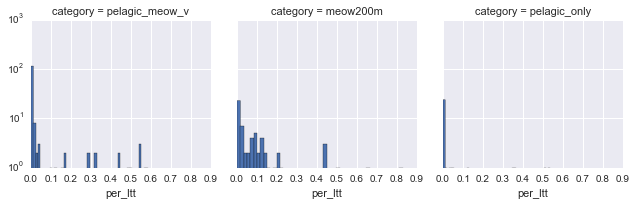

In [20]:
g = sns.FacetGrid(result_agg_10, col="category")
g.map(plt.hist, 'per_ltt', bins=50, log=True)

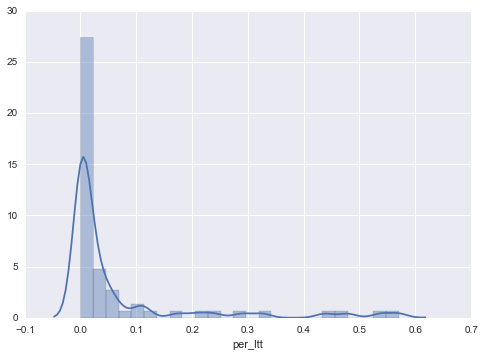

In [21]:
# MEOW province (200m and 200 nautical combined)
result_agg_10_province = attr_merge_10.groupby(['PROVINCE']).apply(apply_func).reset_index()
sns.distplot(result_agg_10_province.per_ltt)

In [22]:
result_agg_10_province.sort_values('per_ltt', ascending=False).head(20)

,PROVINCE,less_than_threshold,per_ltt,base
12,Continental High Antarctic,2.803854e+06,0.570354,4.915992e+06
46,Subantarctic New Zealand,4.179728e+05,0.538576,7.760705e+05
45,Subantarctic Islands,9.810474e+05,0.478338,2.050950e+06
3,Arctic,5.058372e+06,0.437633,1.155847e+07
36,Scotia Sea,6.042116e+05,0.325349,1.857116e+06
25,Marquesas,2.148245e+05,0.289451,7.421788e+05
42,Southern New Zealand,3.443431e+05,0.238514,1.443703e+06
28,None,3.091177e+06,0.209077,1.478489e+07
1,Amsterdam-St Paul,6.889237e+04,0.174105,3.956936e+05
8,Central Polynesia,5.474678e+05,0.114987,4.761110e+06


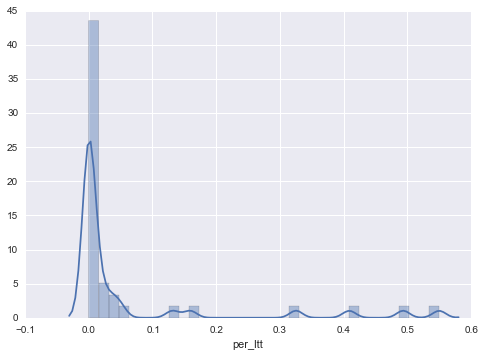

In [23]:
# pelagic province
result_agg_10_pelagic = attr_merge_10.groupby(['PROVINCE_P']).apply(apply_func).reset_index()
sns.distplot(result_agg_10_pelagic.per_ltt)

In [24]:
result_agg_10_pelagic.sort_values('per_ltt', ascending=False).head(20)

,PROVINCE_P,less_than_threshold,per_ltt,base
3,Arctic,2.733379e+06,0.549666,4.972797e+06
1,Antarctic,4.841607e+06,0.493214,9.816438e+06
2,Antarctic Polar Front,9.189585e+05,0.408765,2.248135e+06
35,Subantarctic,7.000664e+05,0.325244,2.152437e+06
20,None,4.515665e+06,0.159273,2.835179e+07
33,Southern Subtropical Front,4.747445e+05,0.131447,3.611677e+06
30,South Central Pacific,8.924580e+05,0.051248,1.741448e+07
10,Equatorial Pacific,2.230339e+05,0.043027,5.183571e+06
8,Eastern Tropical Pacific,1.470141e+05,0.036281,4.052131e+06
32,Southern Indian Ocean,6.851251e+04,0.028446,2.408515e+06


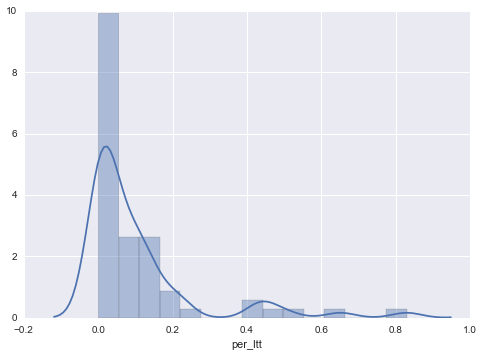

In [25]:
# MEOW province (200m only)
result_agg_10_m200 = attr_merge_10[attr_merge_10.category == 'meow200m'].groupby(['PROVINCE']).apply(apply_func).reset_index()
sns.distplot(result_agg_10_m200.per_ltt)

In [26]:
result_agg_10_m200.sort_values('per_ltt', ascending = False).head(20)

,PROVINCE,less_than_threshold,per_ltt,base
12,Continental High Antarctic,3.343252e+05,0.829469,4.030595e+05
24,Marquesas,2.958568e+03,0.651538,4.540895e+03
43,Subantarctic Islands,4.628220e+04,0.503764,9.187279e+04
1,Amsterdam-St Paul,3.999481e+02,0.442512,9.038129e+02
3,Arctic,3.042845e+06,0.437750,6.951103e+06
34,Scotia Sea,7.053670e+04,0.437160,1.613520e+05
46,Tristan Gough,4.104271e+02,0.223172,1.839063e+03
44,Subantarctic New Zealand,7.815580e+03,0.215398,3.628437e+04
40,Southern New Zealand,5.081087e+04,0.212072,2.395925e+05
32,Red Sea and Gulf of Aden,5.443748e+04,0.192227,2.831938e+05
